<a href="https://colab.research.google.com/github/LuritoCosta/caseZup/blob/main/case_Itau.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Configuração do ambiente e modelagens iniciais

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
df = pd.read_excel('/content/case_assessmentanalytics_vsabr2024.xlsx',sheet_name='Base_Avaliacao')
df_ref = pd.read_excel('/content/case_assessmentanalytics_vsabr2024.xlsx',sheet_name='Nivel_de_necessidade_po')

In [3]:
# ajustes do df_ref
df_ref = df_ref.drop('PAPEL', axis=1)
df_ref = pd.melt(df_ref, id_vars=['ESPECIALIDADE'], value_vars=df_ref.filter(regex=r'\[').columns).sort_values(by=['ESPECIALIDADE'])
df_ref['variable_ajust'] = df_ref['variable'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
df_ref['ESPECIALIDADE_ajust'] = df_ref['ESPECIALIDADE'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)

#ajuste do df_po
df_po = df[['Nome do colaborador avaliado','ESPECIALIDADE_avaliado','[Contexto estratégico] ',
            '[Problem solving]', '[Atitude de dono]', '[Poder de influência]',
            '[Produto como plataforma]', '[Mindset lean e ágil]',
            '[Product discovery]', '[Negócio e indústria]', '[P&L]', '[Dados]']][(df['Papel_comunidade'] == 'PO') & (df['ESPECIALIDADE_avaliado'].isin(['OPERAÇÕES', 'AQ DIGITAL', 'CRÉDITO', 'PRODUTO'])) & (df['Tipo de gestão'] == 'Funcional')]
df_po = pd.melt(df_po, id_vars=['ESPECIALIDADE_avaliado','Nome do colaborador avaliado'], value_vars=df_po.filter(regex=r'\[').columns).sort_values(by=['ESPECIALIDADE_avaliado','Nome do colaborador avaliado'])
df_po['variable_ajust'] = df_po['variable'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
df_po['ESPECIALIDADE_ajust'] = df_po['ESPECIALIDADE_avaliado'].str.replace(r'[^a-zA-Z0-9]', '', regex=True)
df_po = df_po.merge(df_ref, left_on=['ESPECIALIDADE_ajust', 'variable_ajust'],
            right_on=['ESPECIALIDADE_ajust', 'variable_ajust'],
            how='left')
df_po['diferenca'] = (df_po['value_y'] - df_po['value_x'])

# Começo da analise

Nesta analise vamos levar em consideração a base as seguintes premissas:
 - Somente olharemos profissionais com o papel de **PO**
 - Referente as notas so levaremos em consideração notas do tipo **Funcional**
 - E quanto a especialidade so trabalharemos em cima das que tenhamos uma referencia de aptidao para a função que no caso sao: [OPERAÇÕES, AQ DIGITAL, CRÉDITO, PRODUTO]


## Primeira pergunta a ser respondida
  **"1.Nossos POs estão aptos a exercer seus papeis?"**

   Para conseguirmos responder esta pergunta temos como referencia o que é exigido para cada ESPECIALIDADE conforme o print abaixo:

   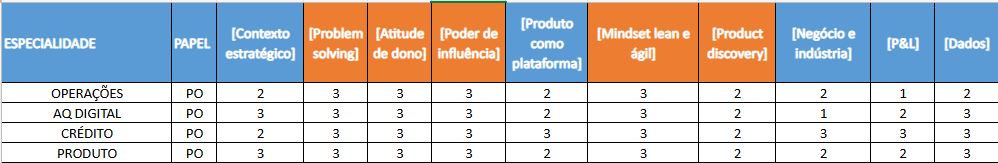

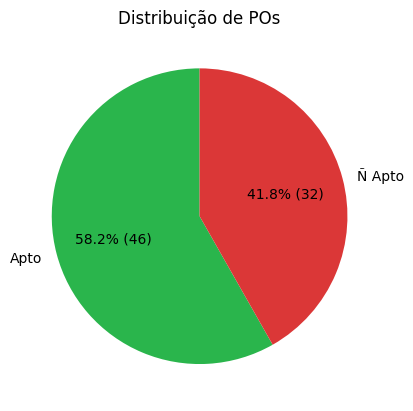

In [17]:
df_po_diff = df_po.groupby(['ESPECIALIDADE_avaliado','Nome do colaborador avaliado']).agg(total = ('diferenca','sum'))
df_po_diff['apto'] = np.where(df_po_diff['total']>= 0,'Apto','Ñ Apto')

apto_counts = df_po_diff.groupby(['apto']).size()
colors = ['#2ab54c', '#db3737']  # Green and Red
plt.pie(apto_counts, labels=apto_counts.index, colors=colors, autopct=lambda pct: f"{pct:.1f}% ({int(pct/100.*apto_counts.sum())})", startangle=90)
plt.title('Distribuição de POs')
plt.show()

Indo direto ao ponto referente a nossa pergunta apenas **58.2%** dos nossos POs estao aptos a exercer as funções de acordo com com nossa tabela de referencia, acima temos a distribuição geral.

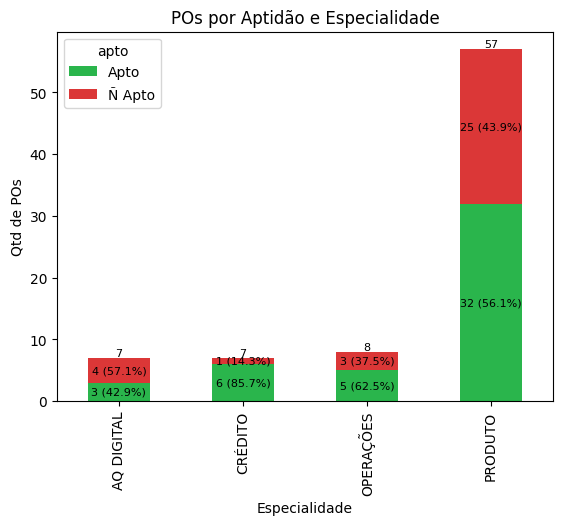

In [16]:
df_po_diff = df_po.groupby(['ESPECIALIDADE_avaliado','Nome do colaborador avaliado']).agg(total = ('diferenca','sum'))
df_po_diff['apto'] = np.where(df_po_diff['total']>= 0,'Apto','Ñ Apto')
df_po_diff.groupby(['ESPECIALIDADE_avaliado','apto']).size()


df_plot = df_po_diff.groupby(['ESPECIALIDADE_avaliado','apto']).size().unstack().fillna(0)

ax = df_plot.plot(kind='bar', stacked=True,color={'Ñ Apto': '#db3737', 'Apto': '#2ab54c'})
for i, (index, row) in enumerate(df_plot.iterrows()):
    total = row.sum()
    for j, value in enumerate(row):
        if value != 0:  # Check for non-zero values
            percentage = (value / total) * 100
            ax.text(i, value/2 + row[:j].sum(), f"{int(value)} ({percentage:.1f}%)", ha='center', va='center', fontsize=8)
for i, total in enumerate(df_plot.sum(axis=1)):
    ax.text(i, total, f"{int(total)}", ha='center', va='bottom', fontsize=8)

plt.title('POs por Aptidão e Especialidade')
plt.xlabel('Especialidade')
plt.ylabel('Qtd de POs')
plt.show()

Aqui quando olhamos a distribuição de aptidão dos POs por especialiade temos algumas conclusões.
 - Temos uma media de **61,8%** de POs Aptos
 - Existe um concentração de POs na especialidade **PRODUTO**
 - Em numeros absolutos conseguentemente **PRODUTO** tem o maior numero de POs não aptos e tambem aptos.
 - Proporcionalmente a especialidade **CRÉDITO** é a que mais tem POs aptos e **AQ DIGITAL** a que tem menos.

**Sugestão de aprofundamento**

Aqui podemos nos aprofundar mais para entender as demanda de cada especialidade, em um cenario hipotetico que as demais especialidades que nao seja **PRODUTO** tenham um volume de demanda equivalente podemos propor uma redistribuição de POs ou um plano de desenvolvimento de novos POs para equalizar o volume de equipes vs demanda.

## Segunda pergunta a ser respondida
  **"2.Quais são as skills que deveríamos propor treinamentos para nossos POs? Qual seria o primeiro treinamento?"**

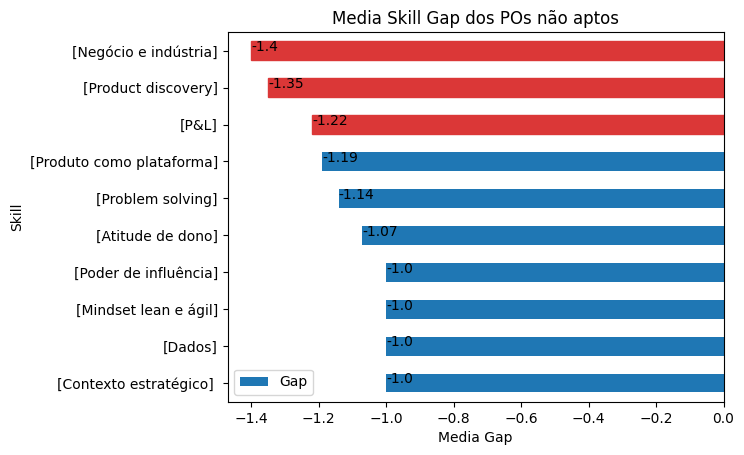

In [18]:
df_po_diff = df_po.groupby(['ESPECIALIDADE_avaliado','Nome do colaborador avaliado','variable_x']).agg(total = ('diferenca','sum'))
df_po_diff['apto'] = np.where(df_po_diff['total']>= 0,'Apto','Ñ Apto')
df_po_diff = df_po_diff[df_po_diff['apto'] == 'Ñ Apto'].groupby(['variable_x']).agg(Gap = ('total','mean')).round(2).sort_values(by=['Gap'],ascending=False)

ax = df_po_diff.plot.barh()
for i, v in enumerate(df_po_diff['Gap']):
    plt.text(v, i, str(v))
    if i >= len(df_po_diff) - 3:
        ax.get_children()[i].set_color('#db3737')

plt.title('Media Skill Gap dos POs não aptos')
plt.xlabel('Media Gap')
plt.ylabel('Skill')
plt.show()


Indo direto ao ponto o grafico acima informa quais são os skills que deveriamos propor treinamentos e a skill que apresentou maior gap com base em nossa tabela de referencia foi a skill **[Negócio e indústria]**.

Fazendo um segregação de skill Gerais e Especifícas:
 - Referente a Geral a primeira a se trabalhar continuaria sendo **[Negócio e indústria]**
 - Referente a Específica seria a **[P&L]**